# Quantum Fourier Transform

## Theory

The QFT is a unitary operation that maps a wavefunction to its classical Fourier transform. Assume that we have a Hilbert space of dimension $D$ and a state
$$|\psi\rangle = \sum_{x=0}^{D-1} \psi(x)|x\rangle.$$
The QFT maps this state into
$$\mathcal{F}|\psi\rangle = \sum_{y=0}^{D-1}\psi(y)|y\rangle,$$
where
$$\psi(y) = \sum_{x=0}^{D-1} \frac{1}{\sqrt{D}}\exp\left(-i\frac{2\pi x y}D\right)|x\rangle.$$

The most usual case of this transform is when the dimension of the Hilbert space corresponds to the states encoded in a quantum register with $N$ qubits, that is $D=2^N.$ The original variable $x$ and the destination "frequency" $y$ can be encoded in this register
$$x = x_1x_2\cdots x_N = \sum_{i=1}^N 2^{N-i} x_i,$$
$$y = y_1y_2\cdots y_N = \sum_{i=1}^N 2^{N-i} y_i.$$

The transformation experienced by one state $|x_1,x_2\ldots x_N\rangle$ can be easily expressed as
$$\mathcal{F}|x\rangle = \sum_{y_1,y_2,\ldots} \frac{1}{2^{N/2}} \prod_{k=1}^N \exp\left(-i 2\pi \sum_r y_k x_r 2^{N-r-k}\right) |y_1,y_2\ldots y_N\rangle.$$

Note that the exponents are irrelevant unless $N<k+r.$ Given this and the fact hat we have all possible combinations of $y_k,$ the output can be written as a product state
$$\mathcal{F}|x\rangle = \left(|0\rangle + \frac{1}{\sqrt{2}}e^{-i2\pi y_1 [0.x_N]}\right)\left(|0\rangle + \frac{1}{\sqrt{2}}e^{-i2\pi y_1 [0.x_{N-1}x_N]}\right)\cdots\left(|0\rangle + \frac{1}{\sqrt{2}}e^{-i2\pi y_1 [0.x_1x_2\cdots x_N]}\right).$$

This transformation can be achieved by a quantum circuit that consists of Hadamard gates (H), condition rotations (R) and an implicit swap of the bits (the $y_1$ appears where the $x_n$ and viceversa)

<a title="Trenar3 [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Q_fourier_nqubits.png"><img src="figures/qft.png" style="width:100%"></a>

## Implementation

We are going to implement this operator for an MPS that consists of $N$ qubits in the $x_1$ to $x_N$ order, forming a matrix product state. We will return a list of MPO's, each of them implementing one layer of the circuit above.

In [1]:
# file: mps/qft.py
import numpy as np
from numpy import pi as π
from mps.state import MPS
from mps.mpo import MPOList, MPO

def qft_mpo(N, sign=-1, **kwdargs):
    """Create an MPOList object representing a Quantum Fourier Transform
    for a quantum register with 'N' qubits.
    
    Parameters
    ----------
    N         -- Number of qubits in a quantum register
    **kwdargs -- All other arguments accepted by MPO
    
    Output
    ------
    mpolist   -- An MPOList object that can be applied '@' to an MPS.
    """
    
    def fix_last(mpo_list):
        A = mpo_list[-1]
        shape = A.shape
        A = np.sum(A, -1).reshape(shape[0],shape[1],shape[2],1)
        return mpo_list[:-1]+[A]
    
    # Tensor doing nothing
    noop = np.eye(2).reshape(1,2,2,1)
    #
    # Beginning Hadamard
    H = np.array([[1, 1],[1,-1]])/np.sqrt(2.)
    Hop = np.zeros((1,2,2,2))
    Hop[0,1,:,1] = H[1,:]
    Hop[0,0,:,0] = H[0,:]
    #
    # Conditional rotations
    R0 = np.zeros((2,2,2,2))
    R0[0,0,0,0] = 1.0
    R0[0,1,1,0] = 1.0
    R0[1,0,0,1] = 1.0
    R1 = np.zeros((2,2,2,2))
    R1[1,1,1,1] = 1.0
    jϕ = sign*1j*π
    rots = [R0 + R1 * np.exp(jϕ/(2**n)) for n in range(1, N)]
    #
    return MPOList([MPO(fix_last([noop]*n + [Hop] + rots[:N-n-1]), **kwdargs)
                    for n in range(0, N)])

def iqft_mpo(N, **kwdargs):
    return qft_mpo(N, +1, kwdargs)

We also provide a one-shot application.

In [2]:
# file: mps/qft.py

def qft(Ψmps, **kwdargs):
    """Apply the Quantum Fourier Transform onto a quantum register
    of qubits encoded in the matrix product state 'Ψ'"""
    return qft_mpo(len(Ψmps), sign=-1, **kwdargs).apply(Ψmps)

def iqft(Ψmps, **kwdargs):
    """Apply the Quantum Fourier Transform onto a quantum register
    of qubits encoded in the matrix product state 'Ψ'"""
    return qft_mpo(len(Ψmps), sign=+1, **kwdargs).apply(Ψmps)

When the QFT is implemented, the most significant qubit ends at the opposite position than in the original state. If this bothers you, use this routine

In [3]:
# file: mps/qft.py

def qft_flip(Ψmps):
    return MPS([np.moveaxis(A, [0,1,2],[2,1,0]) for A in reversed(Ψmps)], error=Ψmps.error())

This is a brute force implementation of the QFT using the full wavefunction

In [4]:
# file: mps/qft.py

def qft_wavefunction(Ψ):
    N = int(round(math.log2(Ψ.size)))
    return np.fft.fft(Ψ)/np.sqrt(Ψ.size)

## Multidimensional versions

Sometimes we only want to do a Quantum Fourier Transform of a subset of qubits. The following functions implement the direct and inverse operators.

In [24]:
# file: mps/qft.py

def qft_nd_mpo(sites, N=None, sign=-1, **kwdargs):
    """Create an MPOList object representing a Quantum Fourier Transform
    for subset of qubits in a quantum register with 'N' qubits.
    
    Parameters
    ----------
    sites     -- Sites on which to apply the QFT, in order of decreasing
                 significance.
    N         -- Number of qubits in a quantum register.
                 Defaults to max(sites)+1.
    sign      -- Sign of the FFT (defaults to -1, direct FFT)
    **kwdargs -- All other arguments accepted by MPO
    
    Output
    ------
    mpolist   -- An MPOList object that can be applied '@' to an MPS.
    """
    if N is None:
        N = max(sites)+1
    #
    # Construct a bare transformation that does nothing
    small_noop = np.eye(2).reshape(1,2,2,1)
    noop = np.eye(2).reshape(2,1,1,2) * small_noop
    #
    # Beginning Hadamard
    H = np.array([[1, 1],[1,-1]])/np.sqrt(2.)
    Hop = np.zeros((2,2,2,2))
    Hop[1,1,:,1] = H[1,:]
    Hop[0,0,:,0] = H[0,:]
    #
    # Conditional rotations
    R0 = np.zeros((2,2,2,2))
    R0[0,0,0,0] = 1.0
    R0[0,1,1,0] = 1.0
    R0[1,0,0,1] = 1.0
    R1 = np.zeros((2,2,2,2))
    R1[1,1,1,1] = 1.0
    jϕ = sign*1j*π
    #
    # Place the Hadamard and rotations according to the instructions
    # in 'sites'. The first index is the control qubit, the other ones
    # are the following qubits in order of decreasing significance.
    def make_layer(sites):
        l = [noop] * N
        for (i,ndx) in enumerate(sites):
            if i == 0:
                l[ndx] = Hop
            else:
                l[ndx] = R0 + R1 * np.exp(jϕ/(2**i))
        for (n,A) in enumerate(l):
            if A is noop:
                l[n] = small_noop
            else:
                a, i, j, b = A.shape
                l[n] = np.sum(A,0).reshape(1,i,j,b)
                break
        for n in reversed(range(N)):
            A = l[n]
            if A is noop:
                l[n] = small_noop
            else:
                a, i, j, b = A.shape
                l[n] = np.sum(A,-1).reshape(a,i,j,1)
                break
        return MPO(l, **kwdargs)
    #
    return MPOList([make_layer(sites[i:]) for i in range(len(sites))])

def iqft_nd_mpo(sites, N=None, **kwdargs):
    return qft_nd_mpo(sites, N=N, sign=+1, **kwdargs)

## Examples

This routine takes a discretized function $\{\Psi(x_i)\}$ and uses the QFT to implement the Fourier transform. It plots both the original and the output. Note that we have to reverse the order of the qubits due to the QFT convention.

In [6]:
from mps.state import vector2mps, MPS, CanonicalMPS
import numpy as np
import matplotlib.pyplot as plt
import math

def qft_test(Ψ, ax1=None, ax2=None, **kwdargs):
    N = int(math.log2(Ψ.size)+0.5)
    Ψmps = MPS(vector2mps(Ψ, [2]*N))
    
    ξmps = qft(Ψmps, **kwdargs)
    D = max(A.shape[0] for A in ξmps)
    print(f'Maximum bond dimension D={D}')
    print(f'Truncation error err={ξmps.error()}')
    ξ = qft_flip(ξmps).tovector()

    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    ax1.plot(Ψ, '-')
    ax1.set_title('$\\Psi(x)$')
    ax1.set_xlabel('$x$')
    c = ax2.plot(np.abs(ξ),'-')
    ax2.plot(np.abs(qft_wavefunction(Ψ)), '--', color=c[0].get_color())
    ax2.set_title('$\\mathcal{F}[\\Psi](k)$')
    ax2.set_xlabel('$k$')

## a) Uniform state

The Fourier transform of the uniform function is a Dirac delta. Note the perfect overlap with the usual FFT

Maximum bond dimension D=128
Truncation error err=0.0


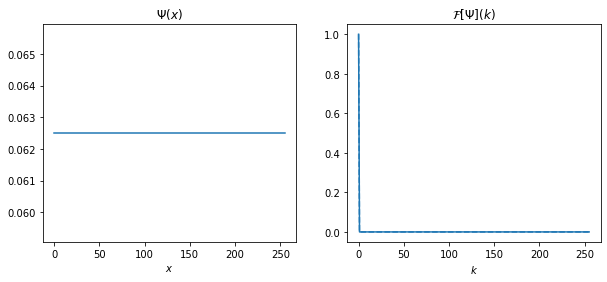

In [7]:
def test1(N=8):
    Ψ = np.ones(2**N) / np.sqrt(2**N)
    qft_test(Ψ)
    
test1(8)

Note how the state above became an unnecesarily complicated MPS. We can use the simplification routine to improve over this.

Maximum bond dimension D=1
Truncation error err=2.9403187623937833e-15


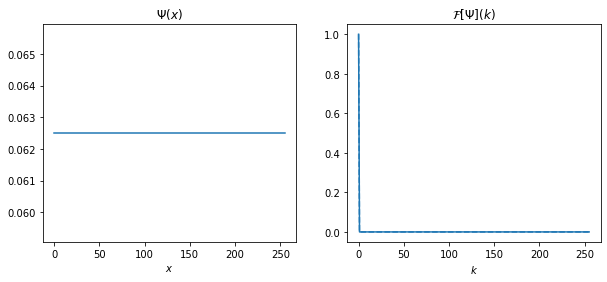

In [8]:
def test1b(N=8):
    Ψ = np.ones(2**N) / np.sqrt(2**N)
    qft_test(Ψ, simplify=True, maxsweeps=10)
    
test1b(8)

## a) Sinusoidal wavefunction

We try various sinusoidal functions. Note how there are two peaks, one at the beginning and one at the end

Maximum bond dimension D=8
Truncation error err=0.0


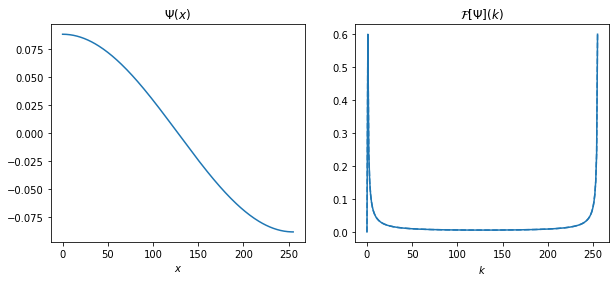

In [9]:
def test2(N=8):
    x = np.linspace(0, math.pi, 2**N)
    Ψ1 = np.cos(x); Ψ1 /= np.linalg.norm(Ψ1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    qft_test(Ψ1, ax1=ax1, ax2=ax2, simplify=True)
    
test2(8)

The reason for this is that numbers above $2^{m/2}$ act as negative versions of those below $2^m.$

Maximum bond dimension D=8
Truncation error err=0.0
Maximum bond dimension D=7
Truncation error err=5.1766831929944156e-15
Maximum bond dimension D=7
Truncation error err=0.0


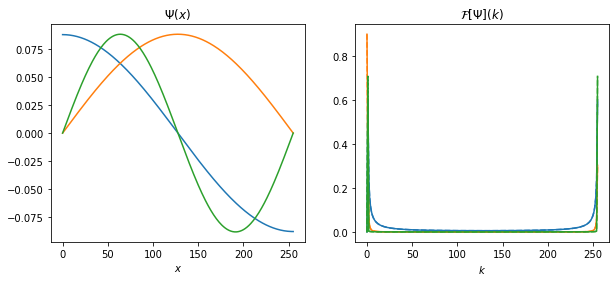

In [10]:
def test3(N=8):
    x = np.linspace(0, math.pi, 2**N)
    Ψ1 = np.cos(x); Ψ1 /= np.linalg.norm(Ψ1)
    Ψ2 = np.sin(x); Ψ2 /= np.linalg.norm(Ψ2)
    Ψ3 = np.sin(2*x); Ψ3 /= np.linalg.norm(Ψ3)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    qft_test(Ψ1, ax1=ax1, ax2=ax2, simplify=True)
    qft_test(Ψ2, ax1=ax1, ax2=ax2, simplify=True)
    qft_test(Ψ3, ax1=ax1, ax2=ax2, simplify=True)
    
test3(8)

If we work with more than 8 qubits, we have to use the MPS simplification routine to work with the state. Otherwise the internal bond dimensions blow up.

Maximum bond dimension D=9
Truncation error err=1.5626106643382253e-14
Maximum bond dimension D=7
Truncation error err=1.1339616899941815e-14
Maximum bond dimension D=6
Truncation error err=5.176683192994417e-15


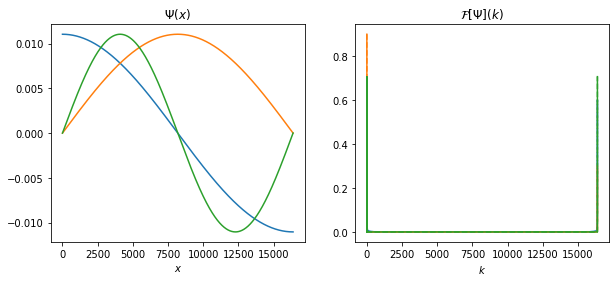

In [11]:
test3(14)

## Tests

In [79]:
# file: mps/test/test_qft.py
from mps.qft import *

In [32]:
# file: mps/test/test_qft.py

import unittest
import numpy as np
import numpy.fft
from mps.test.tools import *
from mps.state import MPS
import scipy.sparse as sp
import matplotlib.pyplot as plt

class TestQFT(unittest.TestCase):
    
    @staticmethod
    def gaussian_mps(N):
        x = np.linspace(-4,4,2**N+1)[:-1]
        ψ = np.exp(-(x**2)/2.);
        ψ /= np.linalg.norm(ψ)
        return MPS.fromvector(ψ, [2]*N), ψ
    
    def test_qft_is_fft(self):
        np.random.seed(1022)
        for N in range(4, 10):
            ψmps, ψ = self.gaussian_mps(N)
            self.assertTrue(similar(qft_flip(qft(ψmps)).tovector(),
                                    numpy.fft.fft(ψ, norm='ortho')))
    
    def test_iqft_is_fft(self):
        np.random.seed(1022)
        for N in range(4, 10):
            ψmps, ψ = self.gaussian_mps(N)
            self.assertTrue(similar(qft_flip(iqft(ψmps)),
                                    numpy.fft.ifft(ψ, norm='ortho')))
    
    def test_qft_nd_vs_qft_flip(self):
        np.random.seed(1022)
        for N in range(4, 10):
            ψmps, _ = self.gaussian_mps(N)
            ξmps1 = qft_nd_mpo(np.arange(N-1,-1,-1)).apply(qft_flip(ψmps))
            ξmps2 = qft_flip(qft_nd_mpo(np.arange(N)).apply(ψmps))
            self.assertTrue(similar(ξmps1, ξmps2))
    
    def test_qft_nd_is_qft(self):
        np.random.seed(1022)
        for N in range(4, 10):
            ψmps, _ = self.gaussian_mps(N)
            self.assertTrue(similar(qft(ψmps), qft_nd_mpo(np.arange(N), N).apply(ψmps)))

    def test_iqft_nd_is_iqft(self):
        np.random.seed(1022)
        for N in range(4, 10):
            ψmps, _ = self.gaussian_mps(N)
            self.assertTrue(similar(iqft(ψmps), iqft_nd_mpo(np.arange(N), N).apply(ψmps)))

In [ ]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestQFT'])
unittest.TextTestRunner(verbosity=2).run(suite1);